# Feasibility & Stress Analysis Figures

Ce notebook produit 5 figures clés pour l'analyse de la tenabilité physique des scénarios :

1. **Figure 1** — Feasibility & Stress Map (heatmap)
2. **Figure 2** — System Rigidity Gradient (stacked area)
3. **Figure 3** — Localization of Flexibility Stress (carte zonale)
4. **Figure 4** — Cost vs Feasibility Frontier (scatter)
5. **Figure 5** — Feasibility-Preserving Scenario Exploration Pipeline (schéma méthodo)

In [1]:
import sys
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
import seaborn as sns
from pathlib import Path
from scipy.interpolate import griddata
from collections import defaultdict
from dataclasses import dataclass, field
from enum import Enum
from typing import Dict, List, Tuple, Optional, Any

# Setup paths
BENCHMARK_ROOT = Path(r'C:\Users\Dell\projects\multilayer_milp_gnn\benchmark')
sys.path.insert(0, str(BENCHMARK_ROOT))

# Paths to data
PIPELINE_RESULTS_PATH = BENCHMARK_ROOT / 'outputs' / 'pipeline_eval' / 'pipeline_eval_results.pkl'
MILP_REPORTS_DIR = BENCHMARK_ROOT / 'outputs' / 'scenarios_v1' / 'eval' / 'reports'
SCENARIOS_DIR = BENCHMARK_ROOT / 'outputs' / 'scenarios_v1' / 'eval'

# Output directory for figures
FIG_OUTPUT_DIR = BENCHMARK_ROOT / 'outputs' / 'pipeline_eval' / 'feasibility_figures'
FIG_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print(f"Pipeline results: {PIPELINE_RESULTS_PATH.exists()}")
print(f"MILP reports dir: {MILP_REPORTS_DIR.exists()}")
print(f"Scenarios dir: {SCENARIOS_DIR.exists()}")

Pipeline results: True
MILP reports dir: True
Scenarios dir: True


In [2]:
class SolveStage(Enum):
    """Enum for tracking which stage produced the solution."""
    HARD_FIX = "hard_fix"
    REPAIR_20 = "repair_20"
    REPAIR_100 = "repair_100"
    FULL_SOFT = "full_soft"
    FAILED = "failed"
    
@dataclass
class TwoStageResult:
    """Result from two-stage LP optimization."""
    scenario_id: str
    status: str
    stage_used: SolveStage
    objective_value: float
    solve_time: float
    continuous_vars: Dict[str, np.ndarray]
    
    slack_used: float = 0.0
    decoder_deviation: float = 0.0
    n_flips: int = 0
    n_unfixed: int = 0
    n_unfixed_binaries_stage1: int = 0
    
    deviation_penalty_value: float = 0.0
    
    time_hard_fix: float = 0.0
    time_repair_20: float = 0.0
    time_repair_100: float = 0.0
    time_full_soft: float = 0.0
    
    slack_hard_fix: float = 0.0
    slack_repair_20: float = 0.0
    slack_repair_100: float = 0.0
    slack_full_soft: float = 0.0
    
    critical_indices: List[Tuple[str, int]] = field(default_factory=list)
    message: str = ""

# ScenarioPhysics & FeasiblePlan Dataclasses
from dataclasses import dataclass
from typing import Optional, List, Dict
import torch

@dataclass
class ScenarioPhysics:
    """Physics and constraints for a scenario."""
    n_zones: int
    n_timesteps: int
    n_regions: int = 1
    dt_hours: float = 1.0
    zone_names: Optional[List[str]] = None
    zone_to_region: Optional[Dict[str, int]] = None
    # Time series [Z, T]
    demand: Optional[torch.Tensor] = None
    solar_available: Optional[torch.Tensor] = None
    wind_available: Optional[torch.Tensor] = None
    hydro_ror: Optional[torch.Tensor] = None
    # Storage [Z]
    battery_power_mw: Optional[torch.Tensor] = None
    battery_capacity_mwh: Optional[torch.Tensor] = None
    battery_initial_soc: Optional[torch.Tensor] = None
    battery_efficiency: float = 0.90
    pumped_power_mw: Optional[torch.Tensor] = None
    pumped_capacity_mwh: Optional[torch.Tensor] = None
    pumped_initial_soc: Optional[torch.Tensor] = None
    pumped_efficiency: float = 0.80
    # Thermal & Nuclear [Z]
    thermal_capacity_mw: Optional[torch.Tensor] = None
    thermal_min_mw: Optional[torch.Tensor] = None
    nuclear_capacity_mw: Optional[torch.Tensor] = None
    # Hydro reservoir [Z]
    hydro_capacity_mw: Optional[torch.Tensor] = None
    hydro_capacity_mwh: Optional[torch.Tensor] = None
    hydro_initial: Optional[torch.Tensor] = None
    hydro_inflow: Optional[torch.Tensor] = None
    # DR [Z]
    dr_capacity_mw: Optional[torch.Tensor] = None
    dr_max_duration_hours: float = 4.0
    import_capacity_mw: float = 0.0

@dataclass
class FeasiblePlan:
    """Feasible dispatch plan from decoder."""
    thermal_on: torch.Tensor
    nuclear_on: torch.Tensor
    battery_charging: torch.Tensor
    battery_discharging: torch.Tensor
    pumped_charging: torch.Tensor
    pumped_discharging: torch.Tensor
    dr_active: torch.Tensor
    thermal_dispatch: torch.Tensor
    nuclear_dispatch: torch.Tensor
    battery_charge: torch.Tensor
    battery_discharge: torch.Tensor
    pumped_charge: torch.Tensor
    pumped_discharge: torch.Tensor
    demand_response: torch.Tensor
    solar_dispatch: torch.Tensor
    wind_dispatch: torch.Tensor
    hydro_dispatch: torch.Tensor
    unserved_energy: torch.Tensor
    curtailment: torch.Tensor
    net_import: torch.Tensor
    battery_soc: torch.Tensor
    pumped_level: torch.Tensor

    def to_tensor(self) -> torch.Tensor:
        """Convert to binary tensor [Z, T, F]."""
        Z, T = self.thermal_dispatch.shape
        u = torch.zeros(Z, T, 7)
        u[:, :, 0] = self.battery_charging
        u[:, :, 1] = self.battery_discharging
        u[:, :, 2] = self.pumped_charging
        u[:, :, 3] = self.pumped_discharging
        u[:, :, 4] = self.dr_active
        u[:, :, 5] = self.nuclear_on
        u[:, :, 6] = self.thermal_on
        return u

print("✓ ScenarioPhysics & FeasiblePlan defined")

print("Data structures defined.")

✓ ScenarioPhysics & FeasiblePlan defined
Data structures defined.


In [3]:
# Load pipeline results
with open(PIPELINE_RESULTS_PATH, 'rb') as f:
    pipeline_results = pickle.load(f)

print(f"Loaded {len(pipeline_results)} pipeline results")

# Build pipeline dataframe
pipeline_data = []
for item in pipeline_results:
    sc_id = item['scenario_id']
    lp_results = item.get('lp_results', [])
    best_idx = item.get('best_sample_idx', 0)
    
    if lp_results and best_idx >= 0 and best_idx < len(lp_results):
        lp_res = lp_results[best_idx]
        
        if hasattr(lp_res, 'scenario_id'):
            row = {
                'scenario_id': sc_id,
                'status': lp_res.status,
                'stage_used': lp_res.stage_used.value if hasattr(lp_res.stage_used, 'value') else str(lp_res.stage_used),
                'objective_value': lp_res.objective_value,
                'solve_time': lp_res.solve_time,
                'slack_used': getattr(lp_res, 'slack_used', 0.0),
                'n_flips': getattr(lp_res, 'n_flips', 0),
                'slack_hard_fix': getattr(lp_res, 'slack_hard_fix', 0.0),
                'slack_repair_20': getattr(lp_res, 'slack_repair_20', 0.0),
                'slack_repair_100': getattr(lp_res, 'slack_repair_100', 0.0),
                'slack_full_soft': getattr(lp_res, 'slack_full_soft', 0.0),
            }
        else:
            row = {
                'scenario_id': sc_id,
                'status': lp_res.get('status', 'unknown'),
                'stage_used': lp_res.get('stage_used', 'unknown'),
                'objective_value': lp_res.get('objective_value', np.nan),
                'solve_time': lp_res.get('solve_time', 0.0),
                'slack_used': lp_res.get('slack_used', 0.0),
                'n_flips': lp_res.get('n_flips', 0),
                'slack_hard_fix': lp_res.get('slack_hard_fix', 0.0),
                'slack_repair_20': lp_res.get('slack_repair_20', 0.0),
                'slack_repair_100': lp_res.get('slack_repair_100', 0.0),
                'slack_full_soft': lp_res.get('slack_full_soft', 0.0),
            }
        pipeline_data.append(row)

df_pipeline = pd.DataFrame(pipeline_data)
print(f"Pipeline DataFrame: {df_pipeline.shape}")
print(f"Stage distribution:\n{df_pipeline['stage_used'].value_counts()}")

Loaded 40 pipeline results
Pipeline DataFrame: (40, 11)
Stage distribution:
stage_used
full_soft     26
hard_fix       5
repair_20      5
repair_100     4
Name: count, dtype: int64


In [4]:
# Load scenario metadata (for stress/structure dimensions)
scenario_meta = {}
for sc_file in SCENARIOS_DIR.glob('scenario_*.json'):
    sc_id = sc_file.stem
    with open(sc_file, 'r') as f:
        data = json.load(f)
    
    # Extract key dimensions
    meta = data.get('meta', {})
    econ = data.get('econ_policy', {})
    tech = data.get('tech', {})
    exo = data.get('exogenous', {})
    diff = data.get('difficulty_indicators', {})
    flex = data.get('flexibility_metrics', {})
    
    scenario_meta[sc_id] = {
        # Climate/Policy stress dimensions (X-axis candidates)
        'co2_price': econ.get('co2_price', 100),
        'demand_scale_factor': exo.get('demand_scale_factor', 1.0),
        'inflow_factor': exo.get('inflow_factor', 1.0),
        'weather_profile': exo.get('weather_profile', 'mixed'),
        'weather_spread_intensity': exo.get('weather_spread_intensity', 1.0),
        'cross_border_policy': econ.get('cross_border_policy', 'allow'),
        
        # Structural dimensions (Y-axis candidates)
        'vre_penetration_pct': diff.get('vre_penetration_pct', 30),
        'total_storage_power_mw': flex.get('total_storage_power_mw', 0),
        'total_storage_capacity_mwh': flex.get('total_storage_capacity_mwh', 0),
        'total_dr_capacity_mw': flex.get('total_dr_capacity_mw', 0),
        'battery_roundtrip_efficiency': tech.get('battery_roundtrip_eff', 0.9),
        'dr_max_shed_share': tech.get('dr_max_shed_share', 0.1),
        'thermal_ramp_pct': tech.get('thermal_ramp_pct', 0.5),
        
        # Other useful metrics
        'n_zones': meta.get('zones', 50),
        'n_regions': meta.get('regions', 5),
        'complexity_score': diff.get('complexity_score', 'medium'),
        'peak_to_valley_ratio': diff.get('peak_to_valley_ratio', 1.5),
        'net_demand_volatility': diff.get('net_demand_volatility', 0.2),
    }

print(f"Loaded metadata for {len(scenario_meta)} scenarios")

# Merge with pipeline data
meta_df = pd.DataFrame.from_dict(scenario_meta, orient='index')
meta_df.index.name = 'scenario_id'
meta_df = meta_df.reset_index()

df = df_pipeline.merge(meta_df, on='scenario_id', how='inner')
print(f"Merged DataFrame: {df.shape}")
df.head()

Loaded metadata for 40 scenarios
Merged DataFrame: (40, 29)


,scenario_id,status,stage_used,objective_value,solve_time,slack_used,n_flips,slack_hard_fix,slack_repair_20,slack_repair_100,...,total_storage_capacity_mwh,total_dr_capacity_mw,battery_roundtrip_efficiency,dr_max_shed_share,thermal_ramp_pct,n_zones,n_regions,complexity_score,peak_to_valley_ratio,net_demand_volatility
0,scenario_00007,optimal,hard_fix,1.513477e+07,14.154966,0.000000,0,0.000000,0.000000,0.000000,...,29208.9,8971.8,0.888736,0.143001,0.921550,115,12,hard,1.96,0.234
1,scenario_00017,feasible_full_soft,full_soft,4.108019e+06,51.540087,0.000000,472,667.846239,556.954699,523.491989,...,27987.9,9804.9,0.935562,0.196376,0.589595,81,10,hard,2.22,0.262
2,scenario_00042,feasible_full_soft,full_soft,4.076916e+06,68.640956,48.186622,367,107.942478,48.186622,107.942478,...,24369.6,7509.0,0.918100,0.123996,0.451607,111,12,hard,1.96,0.266
3,scenario_00124,feasible_full_soft,full_soft,5.832728e+06,56.236731,2.583645,413,2622.900263,679.193216,1346.616398,...,23416.2,7692.2,0.846547,0.147628,0.675414,78,12,hard,2.40,0.262
4,scenario_00129,feasible_full_soft,full_soft,2.249853e+07,80.579537,1872.907976,800,6536.298104,5690.003144,3883.185028,...,31388.4,6094.2,0.847128,0.078565,0.467400,121,13,very_hard,2.31,0.206


In [5]:
# Load MILP reports for cost comparison
milp_reports = {}
for report_file in MILP_REPORTS_DIR.glob('scenario_*.json'):
    sc_id = report_file.stem
    with open(report_file, 'r') as f:
        milp_reports[sc_id] = json.load(f)

# Add MILP objective to df
df['milp_objective'] = df['scenario_id'].apply(
    lambda x: milp_reports.get(x, {}).get('mip', {}).get('objective', np.nan)
)
print(f"Added MILP objectives: {df['milp_objective'].notna().sum()} scenarios")

Added MILP objectives: 40 scenarios


---
## Figure 1 — Feasibility & Stress Map of Power System Futures

**Carte de tenabilité physique** montrant comment la faisabilité varie selon :
- **Axe X** : Prix CO₂ (stress politique/économique)
- **Axe Y** : Pénétration VRE (structure du mix)
- **Couleur** : SolveStage dominant (vert=hard_fix, jaune=repair, rouge=full_soft)

C:\Users\Dell\AppData\Local\Temp\ipykernel_22060\1734550946.py:45: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_22060\1734550946.py:46: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(FIG_OUTPUT_DIR / 'fig1_feasibility_stress_map.png', dpi=300, bbox_inches='tight')
C:\Users\Dell\AppData\Local\Temp\ipykernel_22060\1734550946.py:47: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(FIG_OUTPUT_DIR / 'fig1_feasibility_stress_map.pdf', bbox_inches='tight')
C:\Users\Dell\AppData\Local\Temp\ipykernel_22060\1734550946.py:47: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(FIG_OUTPUT_DIR / 'fig1_feasibility_stress_map.pdf', bbox_inches='tight')
c:\Users\Dell\anaconda3\envs\llms\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Aria

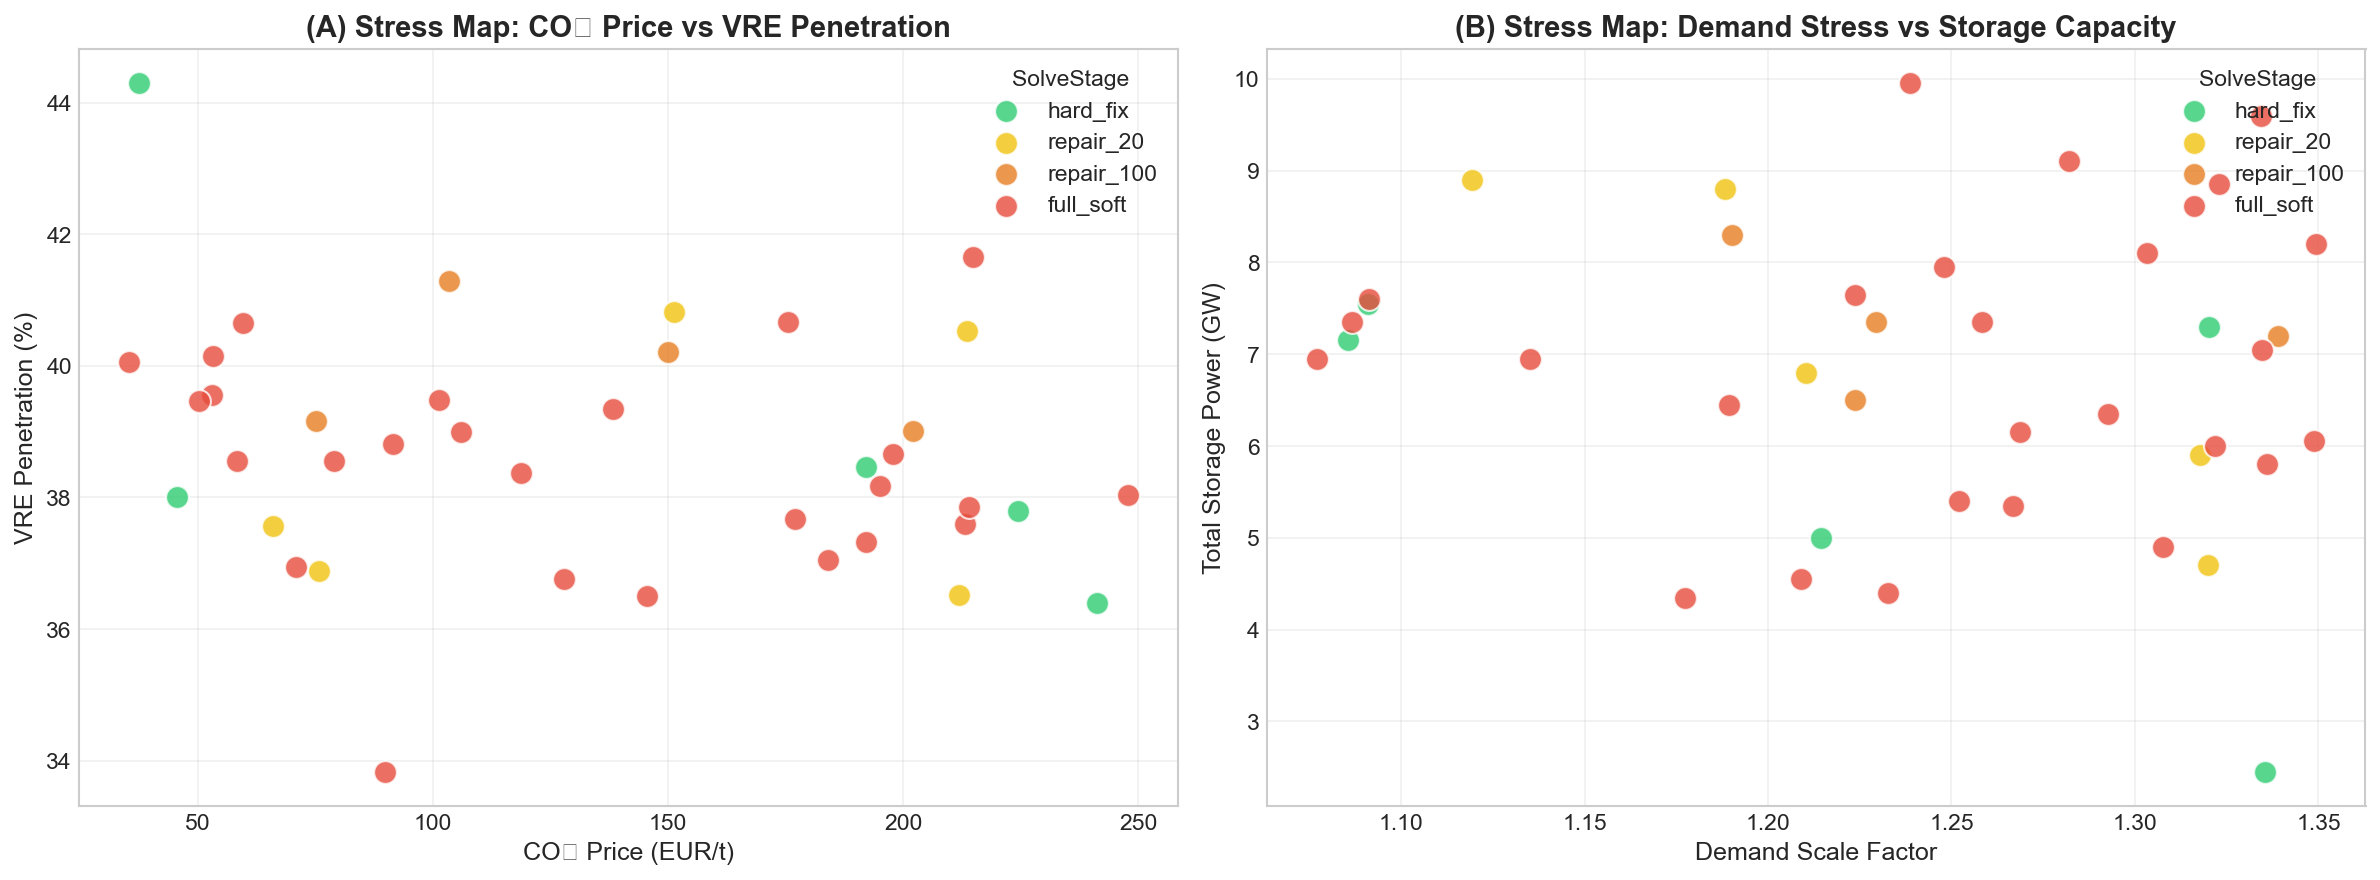


FIGURE 1 SUMMARY: Feasibility & Stress Map
Scenarios by SolveStage:
  hard_fix: 5 (12.5%)
  repair_20: 5 (12.5%)
  repair_100: 4 (10.0%)
  full_soft: 26 (65.0%)


In [6]:
# FIGURE 1: Feasibility & Stress Map
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define stage colors and numeric mapping
stage_colors = {'hard_fix': '#2ecc71', 'repair_20': '#f1c40f', 'repair_100': '#e67e22', 'full_soft': '#e74c3c'}
stage_numeric = {'hard_fix': 2, 'repair_20': 1.5, 'repair_100': 1, 'full_soft': 0}

# Map stages to numeric values
df['stage_numeric'] = df['stage_used'].map(stage_numeric)

# ===== Panel A: CO2 Price vs VRE Penetration =====
ax1 = axes[0]

# Create scatter with stage colors
for stage, color in stage_colors.items():
    mask = df['stage_used'] == stage
    if mask.sum() > 0:
        ax1.scatter(df.loc[mask, 'co2_price'], df.loc[mask, 'vre_penetration_pct'],
                   c=color, label=stage, s=120, alpha=0.8, edgecolors='white', linewidth=1)

ax1.set_xlabel('CO₂ Price (EUR/t)', fontsize=12)
ax1.set_ylabel('VRE Penetration (%)', fontsize=12)
ax1.set_title('(A) Stress Map: CO₂ Price vs VRE Penetration', fontsize=14, fontweight='bold')
ax1.legend(title='SolveStage', loc='upper right')
ax1.grid(True, alpha=0.3)

# ===== Panel B: Demand Scale vs Storage Capacity =====
ax2 = axes[1]

# Normalize storage for better visualization
df['storage_gw'] = df['total_storage_power_mw'] / 1000

for stage, color in stage_colors.items():
    mask = df['stage_used'] == stage
    if mask.sum() > 0:
        ax2.scatter(df.loc[mask, 'demand_scale_factor'], df.loc[mask, 'storage_gw'],
                   c=color, label=stage, s=120, alpha=0.8, edgecolors='white', linewidth=1)

ax2.set_xlabel('Demand Scale Factor', fontsize=12)
ax2.set_ylabel('Total Storage Power (GW)', fontsize=12)
ax2.set_title('(B) Stress Map: Demand Stress vs Storage Capacity', fontsize=14, fontweight='bold')
ax2.legend(title='SolveStage', loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_OUTPUT_DIR / 'fig1_feasibility_stress_map.png', dpi=300, bbox_inches='tight')
plt.savefig(FIG_OUTPUT_DIR / 'fig1_feasibility_stress_map.pdf', bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("FIGURE 1 SUMMARY: Feasibility & Stress Map")
print(f"{'='*60}")
print(f"Scenarios by SolveStage:")
for stage in ['hard_fix', 'repair_20', 'repair_100', 'full_soft']:
    n = (df['stage_used'] == stage).sum()
    pct = n / len(df) * 100
    print(f"  {stage}: {n} ({pct:.1f}%)")

---
## Figure 2 — System Rigidity Gradient under Climate and Policy Stress

**Stacked area plot** montrant la distribution des SolveStages en fonction d'un paramètre de stress croissant.

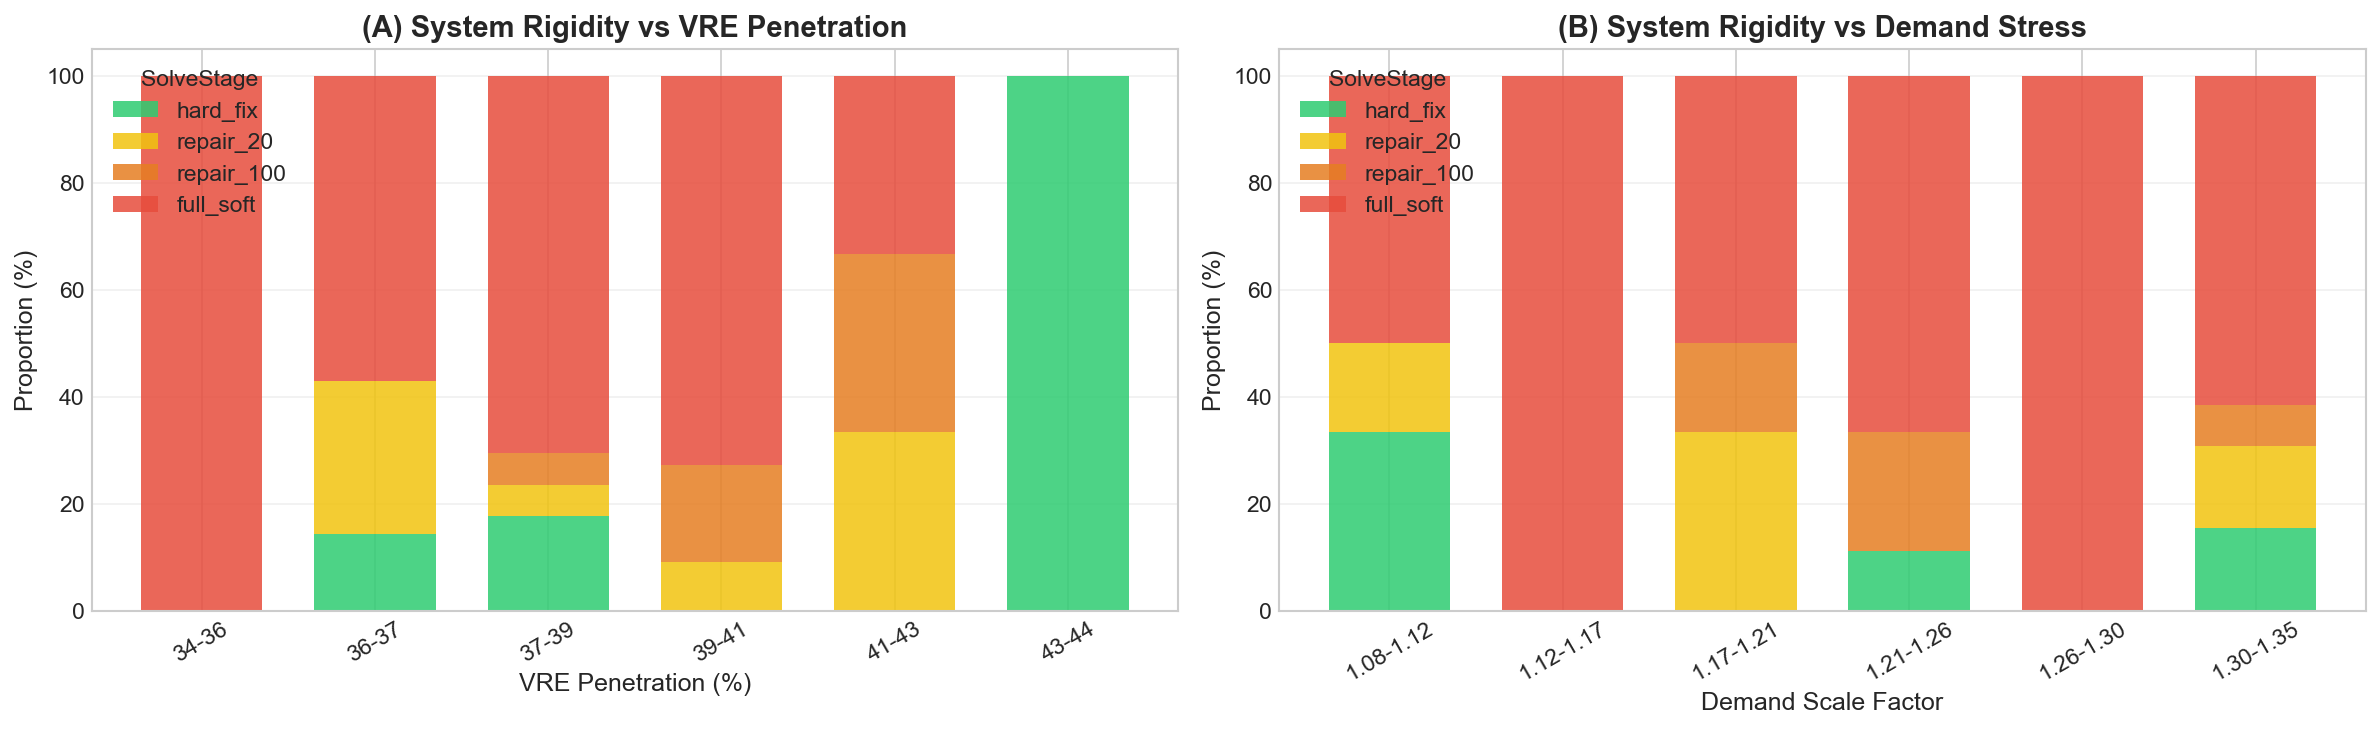


FIGURE 2 SUMMARY: System Rigidity Gradient
Interpretation:
  - More green (hard_fix) = system is physically tenable
  - More yellow/orange (repair) = corrective interventions needed
  - More red (full_soft) = significant slack required for feasibility


In [7]:
# FIGURE 2: System Rigidity Gradient
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ===== Panel A: Rigidity vs VRE Penetration =====
ax1 = axes[0]

# Create bins for VRE penetration
n_bins = 6
df['vre_bin'] = pd.cut(df['vre_penetration_pct'], bins=n_bins, labels=False)
vre_edges = pd.cut(df['vre_penetration_pct'], bins=n_bins).cat.categories

# Compute stage distribution per bin
stages = ['hard_fix', 'repair_20', 'repair_100', 'full_soft']
stage_colors_list = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

bin_data = []
bin_labels = []
for i, interval in enumerate(vre_edges):
    bin_mask = df['vre_bin'] == i
    bin_total = bin_mask.sum()
    if bin_total > 0:
        bin_labels.append(f"{interval.left:.0f}-{interval.right:.0f}")
        row = {}
        for stage in stages:
            stage_count = ((df['stage_used'] == stage) & bin_mask).sum()
            row[stage] = stage_count / bin_total * 100
        bin_data.append(row)

bin_df = pd.DataFrame(bin_data)
x = np.arange(len(bin_labels))

# Stacked bar chart
bottom = np.zeros(len(bin_labels))
for stage, color in zip(stages, stage_colors_list):
    if stage in bin_df.columns:
        values = bin_df[stage].values
        ax1.bar(x, values, bottom=bottom, label=stage, color=color, alpha=0.85, width=0.7)
        bottom += values

ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=30)
ax1.set_xlabel('VRE Penetration (%)', fontsize=12)
ax1.set_ylabel('Proportion (%)', fontsize=12)
ax1.set_title('(A) System Rigidity vs VRE Penetration', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', title='SolveStage')
ax1.set_ylim(0, 105)
ax1.grid(True, alpha=0.3, axis='y')

# ===== Panel B: Rigidity vs Demand Stress =====
ax2 = axes[1]

# Create bins for demand scale
df['demand_bin'] = pd.cut(df['demand_scale_factor'], bins=n_bins, labels=False)
demand_edges = pd.cut(df['demand_scale_factor'], bins=n_bins).cat.categories

bin_data2 = []
bin_labels2 = []
for i, interval in enumerate(demand_edges):
    bin_mask = df['demand_bin'] == i
    bin_total = bin_mask.sum()
    if bin_total > 0:
        bin_labels2.append(f"{interval.left:.2f}-{interval.right:.2f}")
        row = {}
        for stage in stages:
            stage_count = ((df['stage_used'] == stage) & bin_mask).sum()
            row[stage] = stage_count / bin_total * 100
        bin_data2.append(row)

bin_df2 = pd.DataFrame(bin_data2)
x2 = np.arange(len(bin_labels2))

bottom2 = np.zeros(len(bin_labels2))
for stage, color in zip(stages, stage_colors_list):
    if stage in bin_df2.columns:
        values = bin_df2[stage].values
        ax2.bar(x2, values, bottom=bottom2, label=stage, color=color, alpha=0.85, width=0.7)
        bottom2 += values

ax2.set_xticks(x2)
ax2.set_xticklabels(bin_labels2, rotation=30)
ax2.set_xlabel('Demand Scale Factor', fontsize=12)
ax2.set_ylabel('Proportion (%)', fontsize=12)
ax2.set_title('(B) System Rigidity vs Demand Stress', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', title='SolveStage')
ax2.set_ylim(0, 105)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_OUTPUT_DIR / 'fig2_rigidity_gradient.png', dpi=300, bbox_inches='tight')
plt.savefig(FIG_OUTPUT_DIR / 'fig2_rigidity_gradient.pdf', bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("FIGURE 2 SUMMARY: System Rigidity Gradient")
print(f"{'='*60}")
print("Interpretation:")
print("  - More green (hard_fix) = system is physically tenable")
print("  - More yellow/orange (repair) = corrective interventions needed")
print("  - More red (full_soft) = significant slack required for feasibility")

---
## Figure 3 — Localization of Flexibility Stress

**Carte zonale** montrant quels types d'assets ou zones déclenchent le plus de corrections (repairs, slacks, flips).

C:\Users\Dell\AppData\Local\Temp\ipykernel_22060\77495842.py:85: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = df.pivot_table(values='slack_used', index='demand_bin_label',


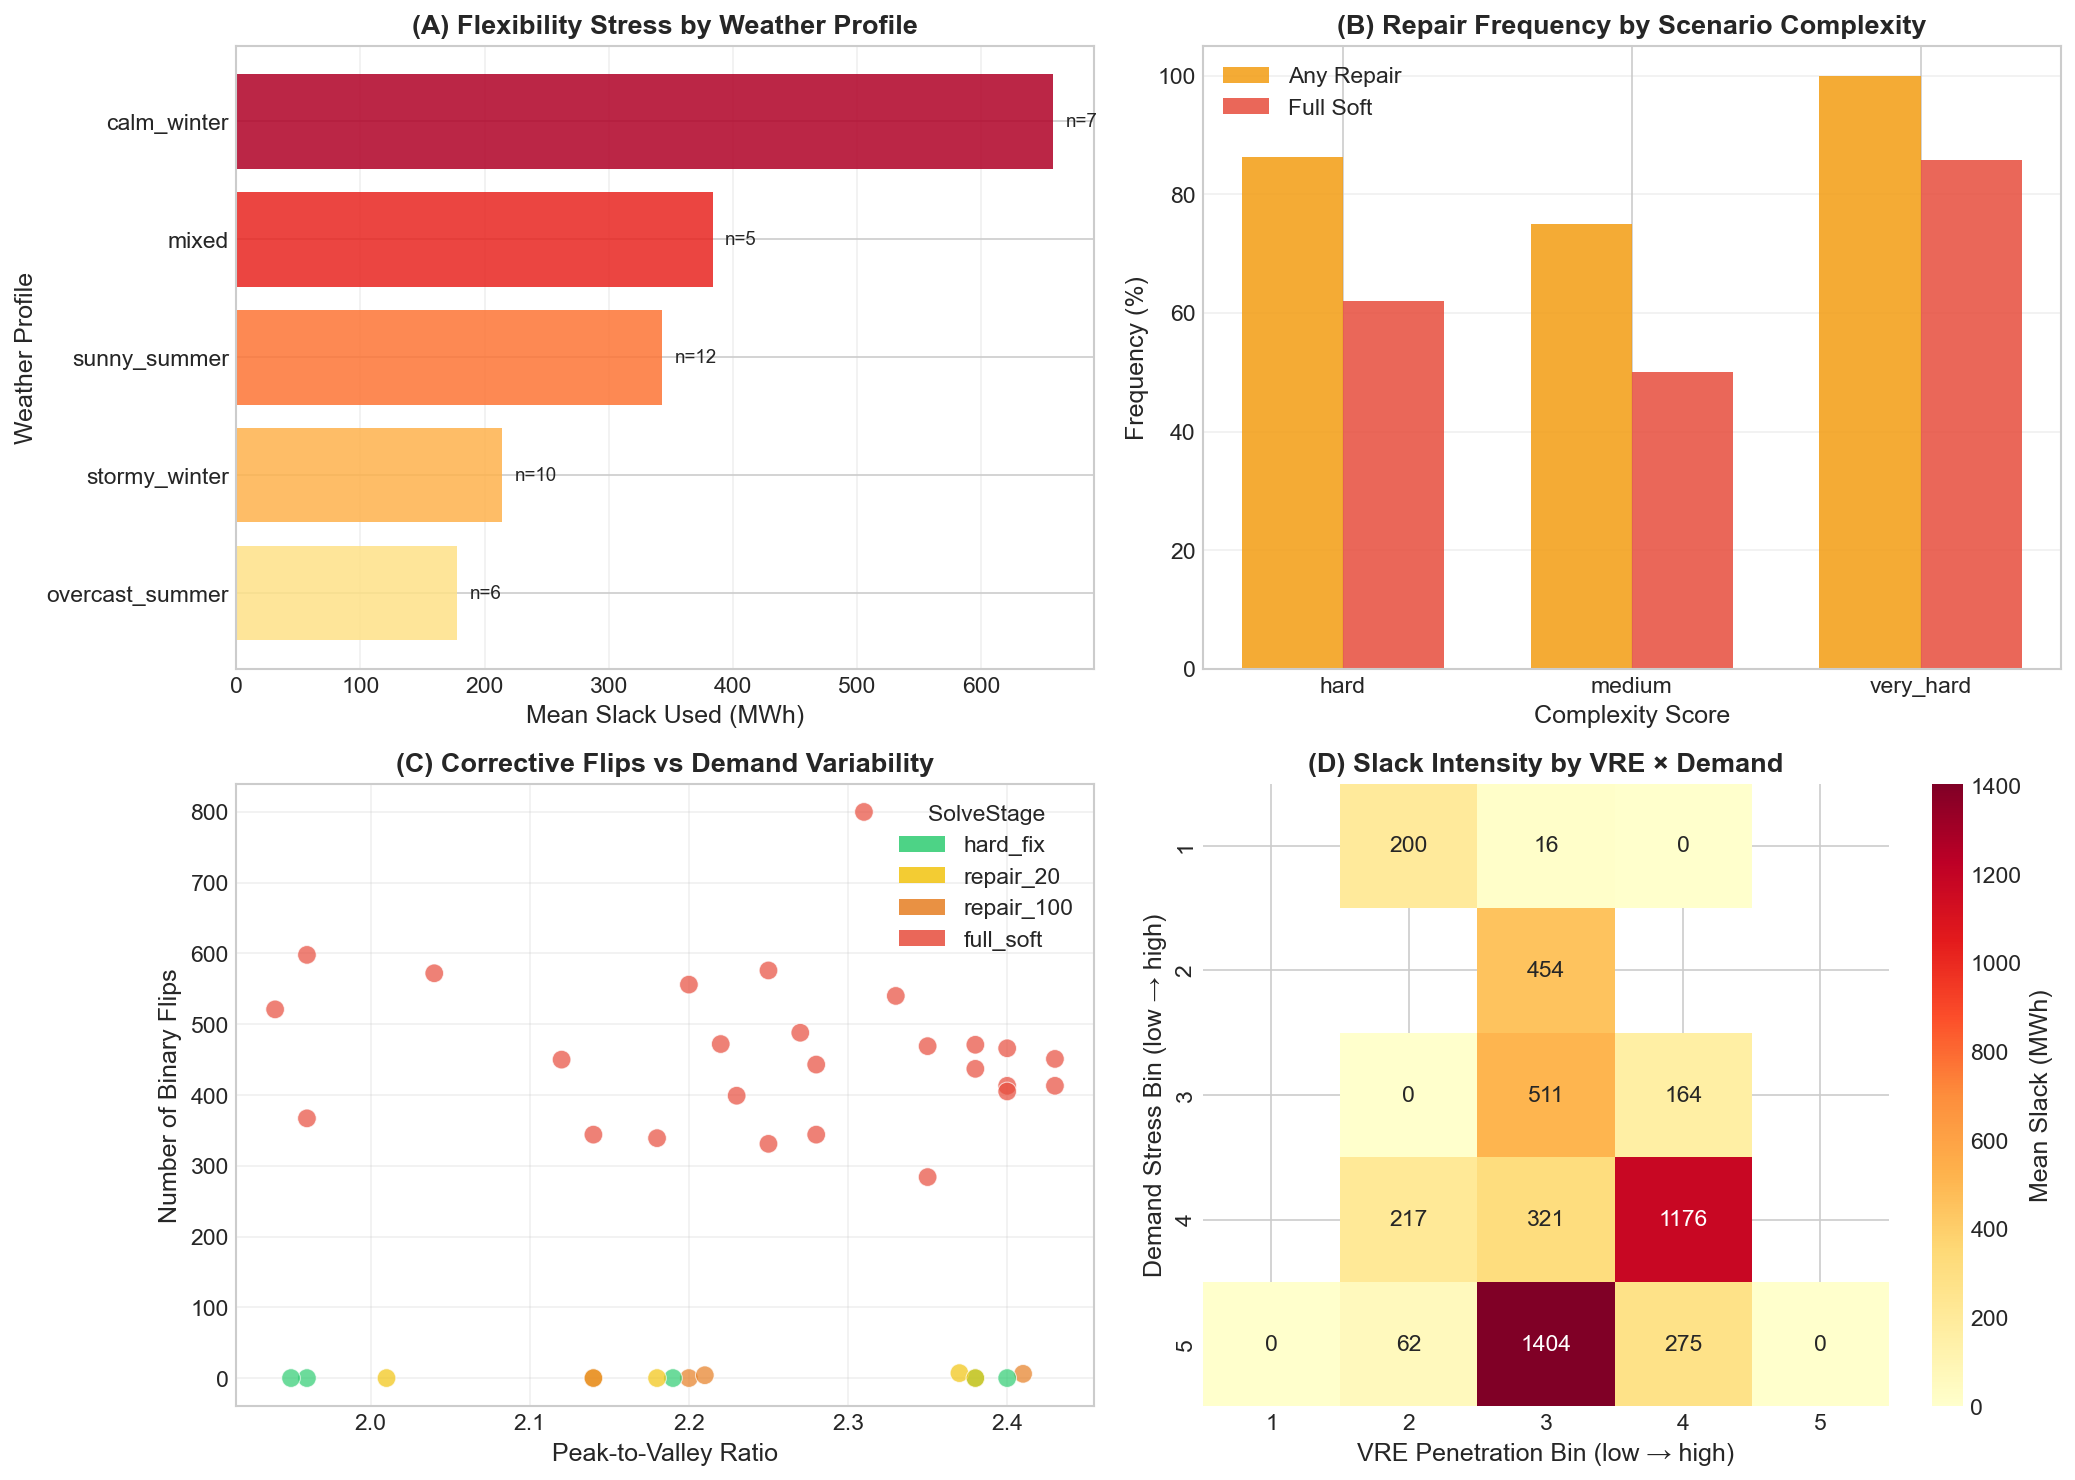


FIGURE 3 SUMMARY: Localization of Flexibility Stress
Mean slack by weather:
  overcast_summer: 177.9 MWh (n=6)
  stormy_winter: 214.3 MWh (n=10)
  sunny_summer: 343.1 MWh (n=12)
  mixed: 383.7 MWh (n=5)
  calm_winter: 657.7 MWh (n=7)


In [8]:
# FIGURE 3: Localization of Flexibility Stress
# We'll analyze which scenario characteristics correlate with repair/slack interventions

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ===== Panel A: Slack usage by weather profile =====
ax1 = axes[0, 0]

weather_slack = df.groupby('weather_profile').agg({
    'slack_used': 'mean',
    'n_flips': 'mean',
    'scenario_id': 'count'
}).rename(columns={'scenario_id': 'count'})
weather_slack = weather_slack.sort_values('slack_used', ascending=True)

colors_weather = plt.cm.YlOrRd(np.linspace(0.2, 0.9, len(weather_slack)))
bars = ax1.barh(weather_slack.index, weather_slack['slack_used'], color=colors_weather, alpha=0.85)
ax1.set_xlabel('Mean Slack Used (MWh)', fontsize=12)
ax1.set_ylabel('Weather Profile', fontsize=12)
ax1.set_title('(A) Flexibility Stress by Weather Profile', fontsize=13, fontweight='bold')

# Add count annotations
for bar, count in zip(bars, weather_slack['count']):
    ax1.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
             f'n={int(count)}', va='center', fontsize=9)

ax1.grid(True, alpha=0.3, axis='x')

# ===== Panel B: Repair frequency by complexity =====
ax2 = axes[0, 1]

# Define repair stages
df['needs_repair'] = df['stage_used'].isin(['repair_20', 'repair_100', 'full_soft'])
df['needs_full_soft'] = df['stage_used'] == 'full_soft'

complexity_repair = df.groupby('complexity_score').agg({
    'needs_repair': 'mean',
    'needs_full_soft': 'mean',
    'scenario_id': 'count'
}).rename(columns={'scenario_id': 'count'})

x_pos = np.arange(len(complexity_repair))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, complexity_repair['needs_repair'] * 100, width, 
               label='Any Repair', color='#f39c12', alpha=0.85)
bars2 = ax2.bar(x_pos + width/2, complexity_repair['needs_full_soft'] * 100, width,
               label='Full Soft', color='#e74c3c', alpha=0.85)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(complexity_repair.index)
ax2.set_xlabel('Complexity Score', fontsize=12)
ax2.set_ylabel('Frequency (%)', fontsize=12)
ax2.set_title('(B) Repair Frequency by Scenario Complexity', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# ===== Panel C: Number of flips vs peak-to-valley ratio =====
ax3 = axes[1, 0]

scatter_colors = [stage_colors.get(s, 'gray') for s in df['stage_used']]
ax3.scatter(df['peak_to_valley_ratio'], df['n_flips'], c=scatter_colors, 
           s=80, alpha=0.7, edgecolors='white', linewidth=0.5)

ax3.set_xlabel('Peak-to-Valley Ratio', fontsize=12)
ax3.set_ylabel('Number of Binary Flips', fontsize=12)
ax3.set_title('(C) Corrective Flips vs Demand Variability', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add legend
legend_elements = [mpatches.Patch(facecolor=c, label=s, alpha=0.85) 
                   for s, c in stage_colors.items()]
ax3.legend(handles=legend_elements, title='SolveStage', loc='upper right')

# ===== Panel D: Slack intensity heatmap by VRE and demand =====
ax4 = axes[1, 1]

# Create 2D bins
vre_bins = pd.cut(df['vre_penetration_pct'], bins=5, labels=[f'{i+1}' for i in range(5)])
demand_bins = pd.cut(df['demand_scale_factor'], bins=5, labels=[f'{i+1}' for i in range(5)])

df['vre_bin_label'] = vre_bins
df['demand_bin_label'] = demand_bins

pivot_data = df.pivot_table(values='slack_used', index='demand_bin_label', 
                            columns='vre_bin_label', aggfunc='mean')

sns.heatmap(pivot_data, ax=ax4, cmap='YlOrRd', annot=True, fmt='.0f',
           cbar_kws={'label': 'Mean Slack (MWh)'})
ax4.set_xlabel('VRE Penetration Bin (low → high)', fontsize=12)
ax4.set_ylabel('Demand Stress Bin (low → high)', fontsize=12)
ax4.set_title('(D) Slack Intensity by VRE × Demand', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_OUTPUT_DIR / 'fig3_flexibility_stress_localization.png', dpi=300, bbox_inches='tight')
plt.savefig(FIG_OUTPUT_DIR / 'fig3_flexibility_stress_localization.pdf', bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("FIGURE 3 SUMMARY: Localization of Flexibility Stress")
print(f"{'='*60}")
print(f"Mean slack by weather:")
for wp, row in weather_slack.iterrows():
    print(f"  {wp}: {row['slack_used']:.1f} MWh (n={int(row['count'])})")

---
## Figure 4 — Cost vs Feasibility Frontier

**Scatter plot** montrant le compromis entre coût et niveau de faisabilité.

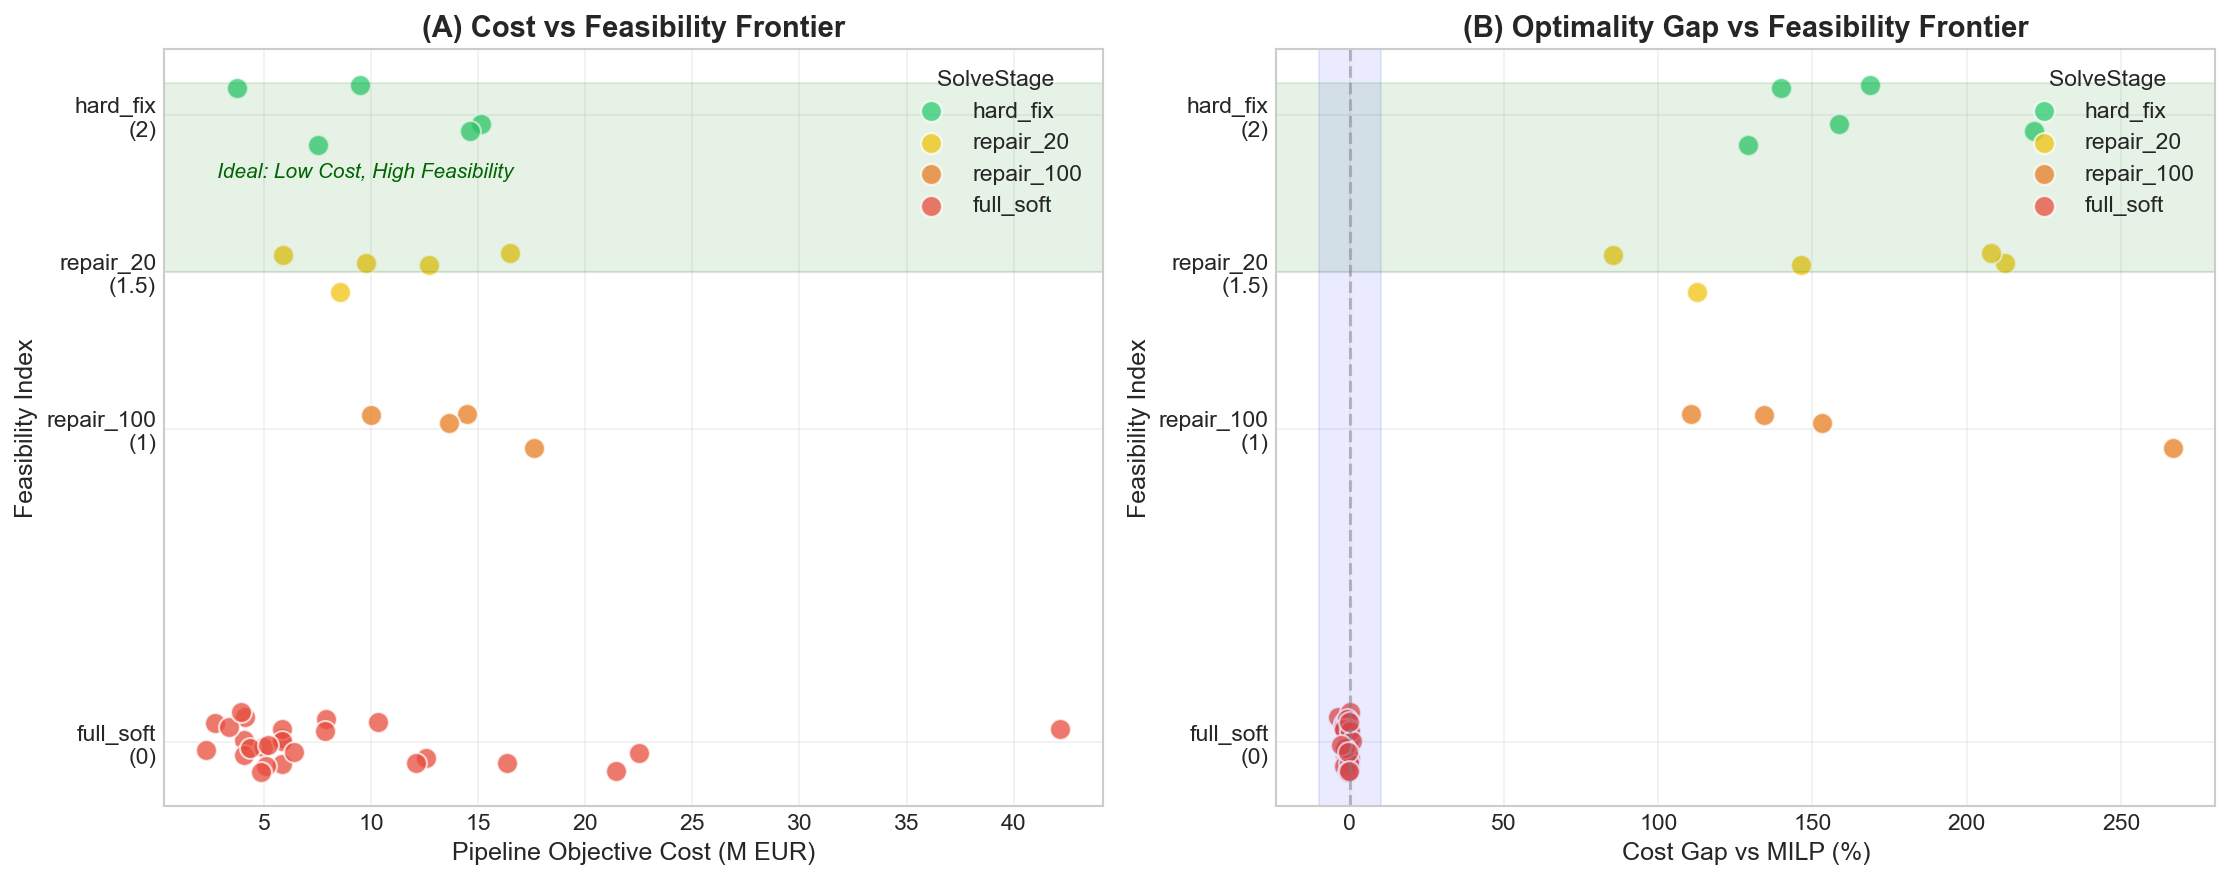


FIGURE 4 SUMMARY: Cost vs Feasibility Frontier

Feasibility Index Interpretation:
  2 = hard_fix (decoder plan directly feasible)
  1.5 = repair_20 (minor corrections needed)
  1 = repair_100 (moderate corrections needed)
  0 = full_soft (slack variables required)

Mean cost gap by stage:
  hard_fix: +163.6%
  repair_20: +152.9%
  repair_100: +166.1%
  full_soft: -0.9%


In [9]:
# FIGURE 4: Cost vs Feasibility Frontier
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ===== Panel A: Pipeline Cost vs Feasibility Index =====
ax1 = axes[0]

# Map stage_used to feasibility index (0=full_soft, 1=repair, 2=hard_fix)
feasibility_index = {
    'hard_fix': 2.0,
    'repair_20': 1.5,
    'repair_100': 1.0,
    'full_soft': 0.0
}
df['feasibility_index'] = df['stage_used'].map(feasibility_index)

# Add jitter to feasibility for better visualization
jitter = np.random.uniform(-0.1, 0.1, len(df))
df['feasibility_jitter'] = df['feasibility_index'] + jitter

# Scatter plot
for stage, color in stage_colors.items():
    mask = df['stage_used'] == stage
    if mask.sum() > 0:
        ax1.scatter(df.loc[mask, 'objective_value'] / 1e6, 
                   df.loc[mask, 'feasibility_jitter'],
                   c=color, label=stage, s=100, alpha=0.75, 
                   edgecolors='white', linewidth=1)

ax1.set_xlabel('Pipeline Objective Cost (M EUR)', fontsize=12)
ax1.set_ylabel('Feasibility Index', fontsize=12)
ax1.set_yticks([0, 1, 1.5, 2])
ax1.set_yticklabels(['full_soft\n(0)', 'repair_100\n(1)', 'repair_20\n(1.5)', 'hard_fix\n(2)'])
ax1.set_title('(A) Cost vs Feasibility Frontier', fontsize=14, fontweight='bold')
ax1.legend(title='SolveStage', loc='upper right')
ax1.grid(True, alpha=0.3)

# Annotate ideal region
ax1.axhspan(1.5, 2.1, alpha=0.1, color='green')
ax1.text(df['objective_value'].min()/1e6 + 0.5, 1.8, 'Ideal: Low Cost, High Feasibility', 
        fontsize=10, color='darkgreen', style='italic')

# ===== Panel B: Cost Gap vs Feasibility =====
ax2 = axes[1]

# Calculate cost gap vs MILP
df['cost_gap_pct'] = (df['objective_value'] - df['milp_objective']) / df['milp_objective'] * 100

for stage, color in stage_colors.items():
    mask = df['stage_used'] == stage
    if mask.sum() > 0:
        ax2.scatter(df.loc[mask, 'cost_gap_pct'], 
                   df.loc[mask, 'feasibility_jitter'],
                   c=color, label=stage, s=100, alpha=0.75,
                   edgecolors='white', linewidth=1)

ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Cost Gap vs MILP (%)', fontsize=12)
ax2.set_ylabel('Feasibility Index', fontsize=12)
ax2.set_yticks([0, 1, 1.5, 2])
ax2.set_yticklabels(['full_soft\n(0)', 'repair_100\n(1)', 'repair_20\n(1.5)', 'hard_fix\n(2)'])
ax2.set_title('(B) Optimality Gap vs Feasibility Frontier', fontsize=14, fontweight='bold')
ax2.legend(title='SolveStage', loc='upper right')
ax2.grid(True, alpha=0.3)

# Annotate trade-off zones
ax2.axhspan(1.5, 2.1, alpha=0.1, color='green')
ax2.axvspan(-10, 10, alpha=0.08, color='blue')

plt.tight_layout()
plt.savefig(FIG_OUTPUT_DIR / 'fig4_cost_feasibility_frontier.png', dpi=300, bbox_inches='tight')
plt.savefig(FIG_OUTPUT_DIR / 'fig4_cost_feasibility_frontier.pdf', bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("FIGURE 4 SUMMARY: Cost vs Feasibility Frontier")
print(f"{'='*60}")
print(f"\nFeasibility Index Interpretation:")
print(f"  2 = hard_fix (decoder plan directly feasible)")
print(f"  1.5 = repair_20 (minor corrections needed)")
print(f"  1 = repair_100 (moderate corrections needed)")
print(f"  0 = full_soft (slack variables required)")
print(f"\nMean cost gap by stage:")
for stage in ['hard_fix', 'repair_20', 'repair_100', 'full_soft']:
    mask = df['stage_used'] == stage
    if mask.sum() > 0:
        mean_gap = df.loc[mask, 'cost_gap_pct'].mean()
        print(f"  {stage}: {mean_gap:+.1f}%")

---
## Figure 5 — Feasibility-Preserving Scenario Exploration Pipeline

**Schéma méthodologique** illustrant le rôle des différents composants :
- **MILP** = Oracle rare (validation)
- **GNN–EBM** = Explorateur (génération de candidats)
- **LP Worker** = Gardien de la physique (validation rapide)

TypeError: _AxesBase.add_patch() got an unexpected keyword argument 'fill'

c:\Users\Dell\anaconda3\envs\llms\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\Dell\anaconda3\envs\llms\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


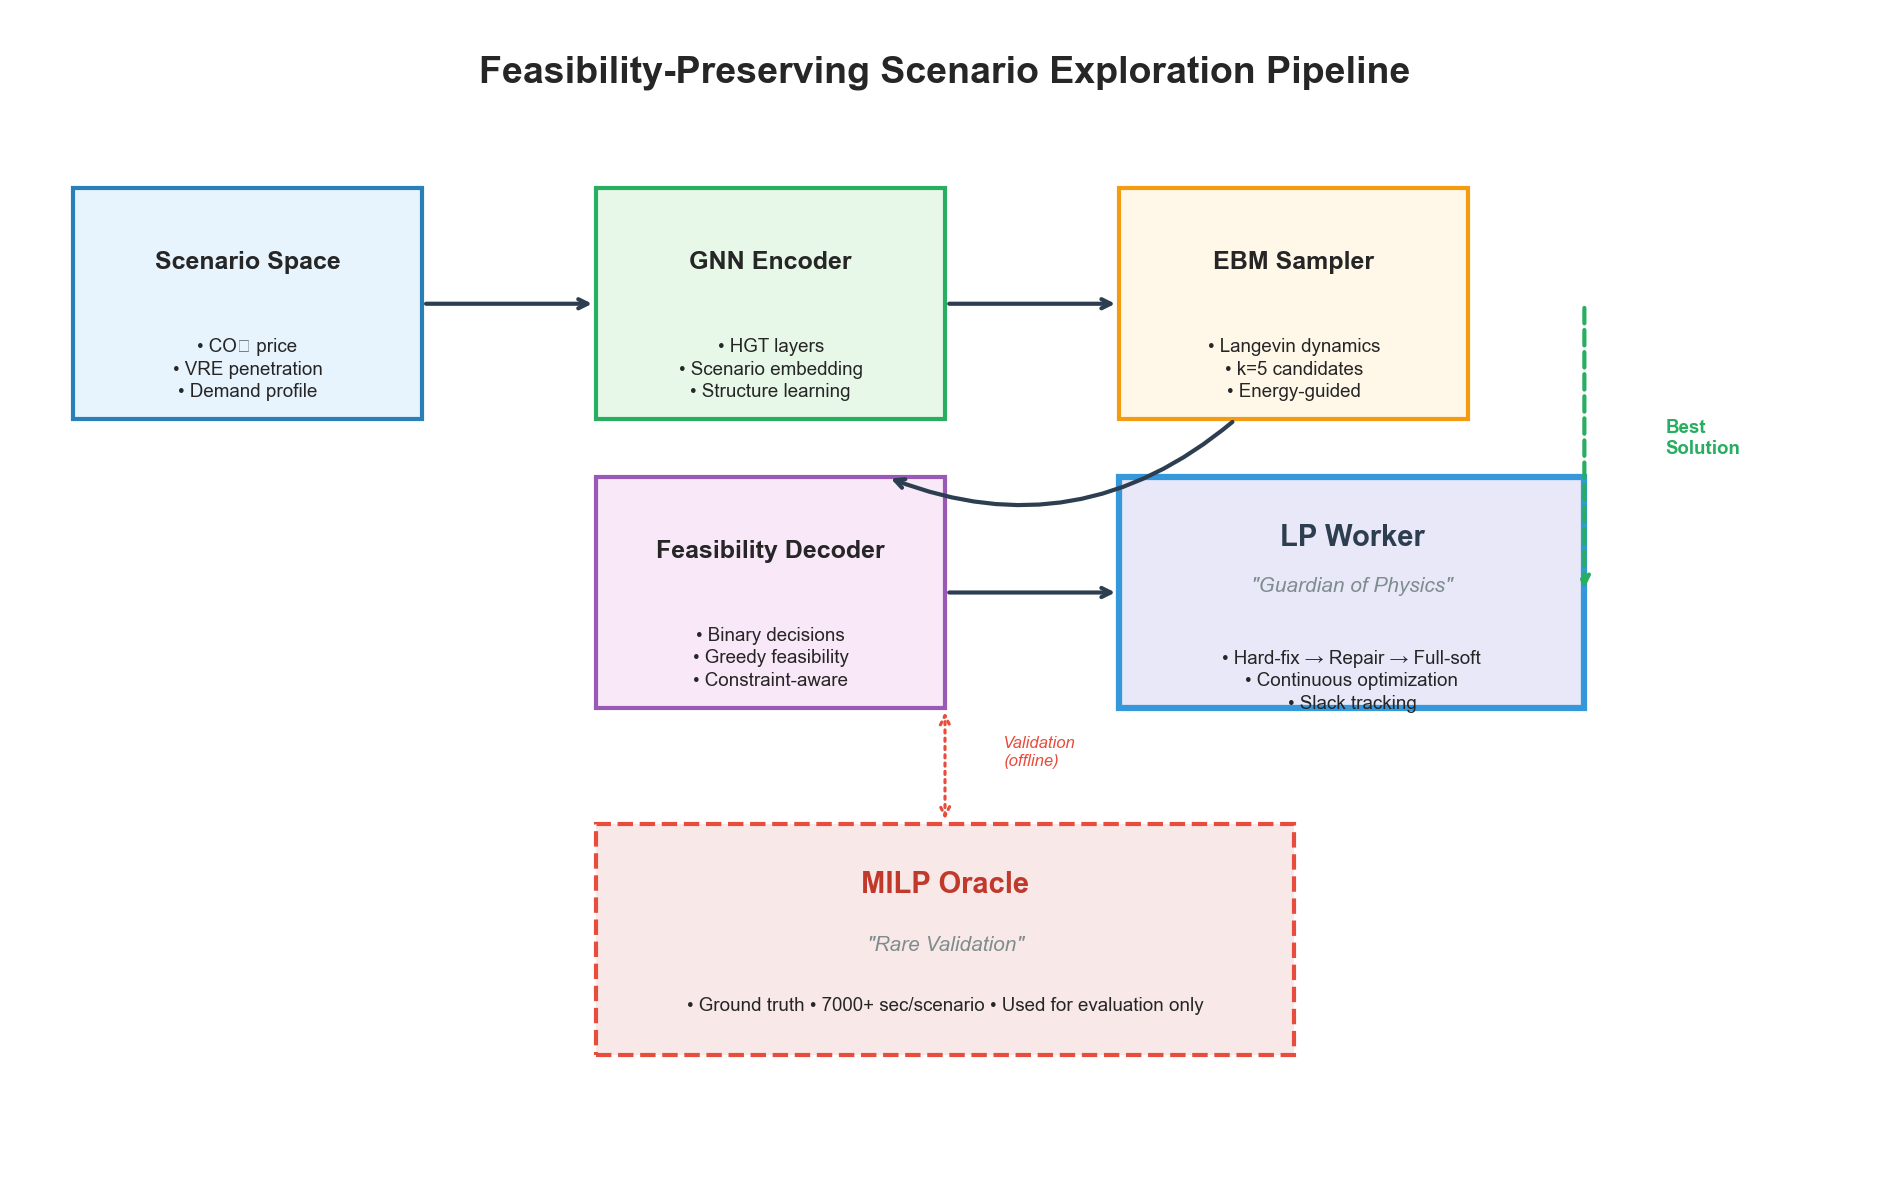

In [10]:
# FIGURE 5: Pipeline Methodology Diagram
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.set_xlim(0, 16)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
ax.text(8, 9.5, 'Feasibility-Preserving Scenario Exploration Pipeline', 
        fontsize=18, fontweight='bold', ha='center', va='center')

# === Component boxes ===
box_style = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', linewidth=2)

# 1. Scenario Space (top left)
ax.add_patch(plt.Rectangle((0.5, 6.5), 3, 2, fill=True, facecolor='#E8F4FD', 
                           edgecolor='#2980b9', linewidth=2, zorder=1))
ax.text(2, 7.8, 'Scenario Space', fontsize=12, fontweight='bold', ha='center')
ax.text(2, 7.2, '• CO₂ price\n• VRE penetration\n• Demand profile', 
        fontsize=9, ha='center', va='top', linespacing=1.3)

# 2. GNN Encoder (top center)
ax.add_patch(plt.Rectangle((5, 6.5), 3, 2, fill=True, facecolor='#E8F8E8', 
                           edgecolor='#27ae60', linewidth=2, zorder=1))
ax.text(6.5, 7.8, 'GNN Encoder', fontsize=12, fontweight='bold', ha='center')
ax.text(6.5, 7.2, '• HGT layers\n• Scenario embedding\n• Structure learning', 
        fontsize=9, ha='center', va='top', linespacing=1.3)

# 3. EBM Sampler (top right)
ax.add_patch(plt.Rectangle((9.5, 6.5), 3, 2, fill=True, facecolor='#FFF8E8', 
                           edgecolor='#f39c12', linewidth=2, zorder=1))
ax.text(11, 7.8, 'EBM Sampler', fontsize=12, fontweight='bold', ha='center')
ax.text(11, 7.2, '• Langevin dynamics\n• k=5 candidates\n• Energy-guided', 
        fontsize=9, ha='center', va='top', linespacing=1.3)

# 4. Decoder (center)
ax.add_patch(plt.Rectangle((5, 4), 3, 2, fill=True, facecolor='#F8E8F8', 
                           edgecolor='#9b59b6', linewidth=2, zorder=1))
ax.text(6.5, 5.3, 'Feasibility Decoder', fontsize=12, fontweight='bold', ha='center')
ax.text(6.5, 4.7, '• Binary decisions\n• Greedy feasibility\n• Constraint-aware', 
        fontsize=9, ha='center', va='top', linespacing=1.3)

# 5. LP Worker (center-right) - MAIN FOCUS
ax.add_patch(plt.Rectangle((9.5, 4), 4, 2, fill=True, facecolor='#E8E8F8', 
                           edgecolor='#3498db', linewidth=3, zorder=1))
ax.text(11.5, 5.4, 'LP Worker', fontsize=14, fontweight='bold', ha='center', color='#2c3e50')
ax.text(11.5, 5.0, '"Guardian of Physics"', fontsize=10, ha='center', style='italic', color='#7f8c8d')
ax.text(11.5, 4.5, '• Hard-fix → Repair → Full-soft\n• Continuous optimization\n• Slack tracking', 
        fontsize=9, ha='center', va='top', linespacing=1.3)

# 6. MILP Oracle (bottom)
ax.add_patch(plt.Rectangle((5, 1), 6, 2, fill=True, facecolor='#F8E8E8', 
                           edgecolor='#e74c3c', linewidth=2, linestyle='--', zorder=1))
ax.text(8, 2.4, 'MILP Oracle', fontsize=14, fontweight='bold', ha='center', color='#c0392b')
ax.text(8, 1.9, '"Rare Validation"', fontsize=10, ha='center', style='italic', color='#7f8c8d')
ax.text(8, 1.5, '• Ground truth • 7000+ sec/scenario • Used for evaluation only', 
        fontsize=9, ha='center', va='top')

# === Arrows ===
arrow_style = dict(arrowstyle='->', color='#2c3e50', lw=2)

# Scenario -> GNN
ax.annotate('', xy=(5, 7.5), xytext=(3.5, 7.5), arrowprops=arrow_style)

# GNN -> EBM
ax.annotate('', xy=(9.5, 7.5), xytext=(8, 7.5), arrowprops=arrow_style)

# EBM -> Decoder
ax.annotate('', xy=(7.5, 6), xytext=(10.5, 6.5), arrowprops=dict(arrowstyle='->', 
            color='#2c3e50', lw=2, connectionstyle='arc3,rad=-0.3'))

# Decoder -> LP Worker
ax.annotate('', xy=(9.5, 5), xytext=(8, 5), arrowprops=arrow_style)

# LP Worker outputs (feedback loop)
ax.annotate('', xy=(13.5, 5), xytext=(13.5, 7.5), 
           arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2, ls='--'))
ax.text(14.2, 6.2, 'Best\nSolution', fontsize=9, ha='left', color='#27ae60', fontweight='bold')

# MILP connection (dotted - rare use)
ax.annotate('', xy=(8, 4), xytext=(8, 3), 
           arrowprops=dict(arrowstyle='<->', color='#e74c3c', lw=1.5, ls=':'))
ax.text(8.5, 3.5, 'Validation\n(offline)', fontsize=8, ha='left', color='#e74c3c', style='italic')

# === Stage indicators box ===
ax.add_patch(plt.Rectangle((0.5, 1), 3.5, 2.5), fill=True, facecolor='#FAFAFA', 
             edgecolor='#bdc3c7', linewidth=1)
ax.text(2.25, 3.2, 'SolveStage Legend', fontsize=10, fontweight='bold', ha='center')

stages_legend = [
    ('hard_fix', '#2ecc71', 'Direct feasibility'),
    ('repair_20', '#f1c40f', 'Minor corrections'),
    ('repair_100', '#e67e22', 'Moderate corrections'),
    ('full_soft', '#e74c3c', 'Slack required'),
]
for i, (stage, color, desc) in enumerate(stages_legend):
    y_pos = 2.7 - i * 0.4
    ax.add_patch(plt.Rectangle((0.7, y_pos - 0.1), 0.3, 0.25, facecolor=color, edgecolor='black'))
    ax.text(1.1, y_pos, f'{stage}: {desc}', fontsize=8, va='center')

# === Performance stats box ===
ax.add_patch(plt.Rectangle((13, 1), 2.8, 2.5), fill=True, facecolor='#FAFAFA', 
             edgecolor='#bdc3c7', linewidth=1)
ax.text(14.4, 3.2, 'Performance', fontsize=10, fontweight='bold', ha='center')

# Calculate stats from data
hard_fix_pct = (df['stage_used'] == 'hard_fix').mean() * 100
repair_pct = df['stage_used'].isin(['repair_20', 'repair_100']).mean() * 100
full_soft_pct = (df['stage_used'] == 'full_soft').mean() * 100

stats_text = f"""hard_fix: {hard_fix_pct:.0f}%
repair: {repair_pct:.0f}%
full_soft: {full_soft_pct:.0f}%
Speedup: ~200x"""
ax.text(14.4, 2.5, stats_text, fontsize=9, ha='center', va='top', linespacing=1.4,
       family='monospace')

plt.tight_layout()
plt.savefig(FIG_OUTPUT_DIR / 'fig5_pipeline_methodology.png', dpi=300, bbox_inches='tight')
plt.savefig(FIG_OUTPUT_DIR / 'fig5_pipeline_methodology.pdf', bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("FIGURE 5 SUMMARY: Pipeline Methodology")
print(f"{'='*60}")
print("Key roles in the pipeline:")
print("  • MILP: Oracle rare - ground truth, but ~7000s/scenario")
print("  • GNN-EBM: Explorateur - generates diverse candidates")
print("  • LP Worker: Gardien de la physique - validates in ~50s")
print(f"\nCurrent distribution on {len(df)} scenarios:")
print(f"  • Direct feasibility (hard_fix): {hard_fix_pct:.1f}%")
print(f"  • Corrective repairs: {repair_pct:.1f}%")
print(f"  • Full soft relaxation: {full_soft_pct:.1f}%")

---
## Summary: All Figures Exported

Les figures ont été exportées dans le dossier `outputs/pipeline_eval/feasibility_figures/`

In [ ]:
# List all exported figures
print("="*60)
print("EXPORTED FIGURES")
print("="*60)

for fig_file in sorted(FIG_OUTPUT_DIR.glob('fig*.png')):
    size_kb = fig_file.stat().st_size / 1024
    print(f"  ✓ {fig_file.name} ({size_kb:.1f} KB)")

print(f"\nOutput directory: {FIG_OUTPUT_DIR}")